In [65]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import re
from Constants import *
from Preprocessing import *
from Models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
Const.tuned_decision_model

'final_decision_model_statedecisions_input132_dims600_dropout0.5,0.9.pt'

In [102]:
def load_trained_models():
    files = [Const.model_dir + f for f in Const.tuned_transition_models]
    decision_file = Const.model_dir + Const.tuned_decision_model
    [model1,model2,model3] = [torch.load(file) for file in files]
    decision_model = torch.load(decision_file)
    return decision_model, model1,model2,model3
decision_model, transition_model1, transition_model2, outcome_model =load_trained_models()
decision_model

DecisionAttentionModel(
  (input_dropout): Dropout(p=0.5, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=210, out_features=600, bias=True)
  )
  (batchnorm): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax(dim=1)
  (final_layer): Linear(in_features=600, out_features=6, bias=True)
  (resize_layer): Linear(in_features=97, out_features=210, bias=True)
  (attentions): ModuleList(
    (0): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=210, out_features=210, bias=True)
    )
  )
  (norms): ModuleList(
    (0): LayerNorm((210,), eps=1e-05, elementwise_affine=True)
  )
  (activation): ReLU()
)

In [4]:
data = DTDataset()
data.processed_df

/data/DigitalTwinVis/python/Preprocessing.py:189: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:203: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.means = self.processed_df.mean(axis=0)
/data/DigitalTwinVis/python/Preprocessing.py:204: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.stds = self.processed_df.std(axis=0)


,hpv,age,packs_per_year,smoking_status,gender,Aspiration rate Pre-therapy,total_dose,dose_fraction,1A1B,1A6,...,SD Primary 2,CR Nodal 2,PR Nodal 2,SD Nodal 2,Decision 1 (Induction Chemo) Y/N,Decision 2 (CC / RT alone),Decision 3 Neck Dissection (Y/N),Overall Survival (4 Years),FT,Aspiration rate Post-therapy
id,,,,,,,,,,,,,,,,,,,,,
3,1,55.969444,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,0,0,0
5,0,20.950000,38.0,1.0,1,0,72.00,1.800000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,0
6,1,69.930556,35.0,1.0,0,1,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,1
7,1,72.319444,0.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,1,0
8,1,59.730556,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,1,49.566667,30.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,1,0,0
10202,0,48.705556,30.0,1.0,1,0,72.00,1.714286,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,1,1,1,0
10203,1,77.116667,0.0,0.0,1,0,70.00,2.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,1,0,0


In [5]:

data.get_state('baseline').iloc[0].to_dict()

{'1A': 0.0,
 '1A1B': 0.0,
 '1A6': 0.0,
 '1B': 0.0,
 '1B2A': 0.0,
 '1B3': 0.0,
 '2A': 1.0,
 '2A2B': 1.0,
 '2A3': 1.0,
 '2B': 1.0,
 '2B5A': 0.0,
 '3': 1.0,
 '34': 0.0,
 '35A': 0.0,
 '36': 0.0,
 '4': 0.0,
 '45B': 0.0,
 '46': 0.0,
 '5A': 0.0,
 '5A5B': 0.0,
 '5B': 0.0,
 '6': 0.0,
 'AJCC_1': 1,
 'AJCC_2': 0,
 'AJCC_3': 0,
 'AJCC_4': 0,
 'Aspiration rate Pre-therapy': 0,
 'DLT (Y/N)': 0,
 'DLT_Grade': 0,
 'N-category_0': 0,
 'N-category_1': 1,
 'N-category_2': 0,
 'N-category_3': 0,
 'Pathological Grade_0': 1,
 'Pathological Grade_1': 0,
 'Pathological Grade_2': 0,
 'Pathological Grade_3': 0,
 'Pathological Grade_4': 0,
 'RPLN': 0.0,
 'T-category_1': 0,
 'T-category_2': 1,
 'T-category_3': 0,
 'T-category_4': 0,
 'age': 55.9694444444444,
 'bilateral': False,
 'contra_spread': 0.0,
 'dose_fraction': 2.2,
 'gender': 1,
 'hpv': 1,
 'ips_spread': 0.8,
 'ln_cluster_1': 1,
 'ln_cluster_2': 0,
 'ln_cluster_3': 0,
 'ln_cluster_4': 0,
 'packs_per_year': 0.0,
 'smoking_status': 0.0,
 'subsite_BOT': 1,


In [6]:
def df_to_torch(df,ttype  = torch.FloatTensor):
    values = df.values.astype(float)
    values = torch.from_numpy(values)
    return values.type(ttype)

def get_decision_input(dataset,state=0,ids=None):
    baseline = data.get_state('baseline')
    dlt1 = data.get_state('dlt1')
    dlt2 = data.get_state('dlt2')
    pd1 = data.get_state('pd_states1')
    pd2 = data.get_state('pd_states2')
    nd1 = data.get_state('nd_states1')
    nd2 = data.get_state('nd_states2')
    modifications = data.get_state('modifications')
    ccs = data.get_state('ccs')
    if state < 2:
        pd = pd1.copy()
        nd = nd1.copy()
        dlt2.values[:,:] = np.zeros(dlt2.shape)
        ccs.values[:,:] = np.zeros(ccs.shape)
        if state < 1:
            dlt1.values[:,:] = np.zeros(dlt1.shape)
            modifications.values[:,:] = np.zeros(modifications.shape)
            pd.values[:,:] = np.zeros(pd.shape)
            nd.values[:,:] = np.zeros(nd.shape)
    else:
        pd = pd2.copy()
        nd = nd2.copy()
        
    output = [baseline, dlt1, dlt2, pd1, nd1,ccs,modifications]
    if ids is not None:
        output = [o.loc[ids] for o in output]
    return output
[f.columns for f in get_decision_input(data,ids=[5])]

[Index(['1A', '1A1B', '1A6', '1B', '1B2A', '1B3', '2A', '2A2B', '2A3', '2B',
        '2B5A', '3', '34', '35A', '36', '4', '45B', '46', '5A', '5A5B', '5B',
        '6', 'AJCC_1', 'AJCC_2', 'AJCC_3', 'AJCC_4',
        'Aspiration rate Pre-therapy', 'DLT (Y/N)', 'DLT_Grade', 'N-category_0',
        'N-category_1', 'N-category_2', 'N-category_3', 'Pathological Grade_0',
        'Pathological Grade_1', 'Pathological Grade_2', 'Pathological Grade_3',
        'Pathological Grade_4', 'RPLN', 'T-category_1', 'T-category_2',
        'T-category_3', 'T-category_4', 'age', 'bilateral', 'contra_spread',
        'dose_fraction', 'gender', 'hpv', 'ips_spread', 'ln_cluster_1',
        'ln_cluster_2', 'ln_cluster_3', 'ln_cluster_4', 'packs_per_year',
        'smoking_status', 'subsite_BOT', 'subsite_GPS', 'subsite_NOS',
        'subsite_Soft palate', 'subsite_Tonsil', 'total_dose'],
       dtype='object'),
 Index(['DLT_Gastrointestinal', 'DLT_Hematological', 'DLT_Neurological',
        'DLT_Infection (

In [7]:
def get_inputkey_order(dataset,state=0):
    return [list(f.columns) for f in get_decision_input(dataset,state=state)]


get_inputkey_order(data)

[['1A',
  '1A1B',
  '1A6',
  '1B',
  '1B2A',
  '1B3',
  '2A',
  '2A2B',
  '2A3',
  '2B',
  '2B5A',
  '3',
  '34',
  '35A',
  '36',
  '4',
  '45B',
  '46',
  '5A',
  '5A5B',
  '5B',
  '6',
  'AJCC_1',
  'AJCC_2',
  'AJCC_3',
  'AJCC_4',
  'Aspiration rate Pre-therapy',
  'DLT (Y/N)',
  'DLT_Grade',
  'N-category_0',
  'N-category_1',
  'N-category_2',
  'N-category_3',
  'Pathological Grade_0',
  'Pathological Grade_1',
  'Pathological Grade_2',
  'Pathological Grade_3',
  'Pathological Grade_4',
  'RPLN',
  'T-category_1',
  'T-category_2',
  'T-category_3',
  'T-category_4',
  'age',
  'bilateral',
  'contra_spread',
  'dose_fraction',
  'gender',
  'hpv',
  'ips_spread',
  'ln_cluster_1',
  'ln_cluster_2',
  'ln_cluster_3',
  'ln_cluster_4',
  'packs_per_year',
  'smoking_status',
  'subsite_BOT',
  'subsite_GPS',
  'subsite_NOS',
  'subsite_Soft palate',
  'subsite_Tonsil',
  'total_dose'],
 ['DLT_Gastrointestinal',
  'DLT_Hematological',
  'DLT_Neurological',
  'DLT_Infection (Pneu

In [103]:
def get_embeddings(dataset,dm,states=[0,1,2]):
    embeddings = []
    decisions_optimal = [[] for i in states]
    decisions_imitation = [[] for i in states]
    for i,state in enumerate(states):
        x = get_decision_input(dataset)
        x = torch.cat([df_to_torch(f) for f in x],axis=1)
        embedding = dm.get_embedding(x,position = state)
        decision = dm(x,position=state).cpu().detach().numpy()
        decisions_optimal[i].append(decision[:,state])
        decisions_imitation[i].append(decision[:,state+3])
        embeddings.append(embedding.cpu().detach().numpy())
    return embeddings,np.array(decisions_optimal).reshape(len(states),-1), np.array(decisions_imitation).reshape(len(states),-1)
embeddings, decisions_optimal, decisions_imitation = get_embeddings(data,decision_model)
[e.shape for e in embeddings]

[(536, 600), (536, 600), (536, 600)]

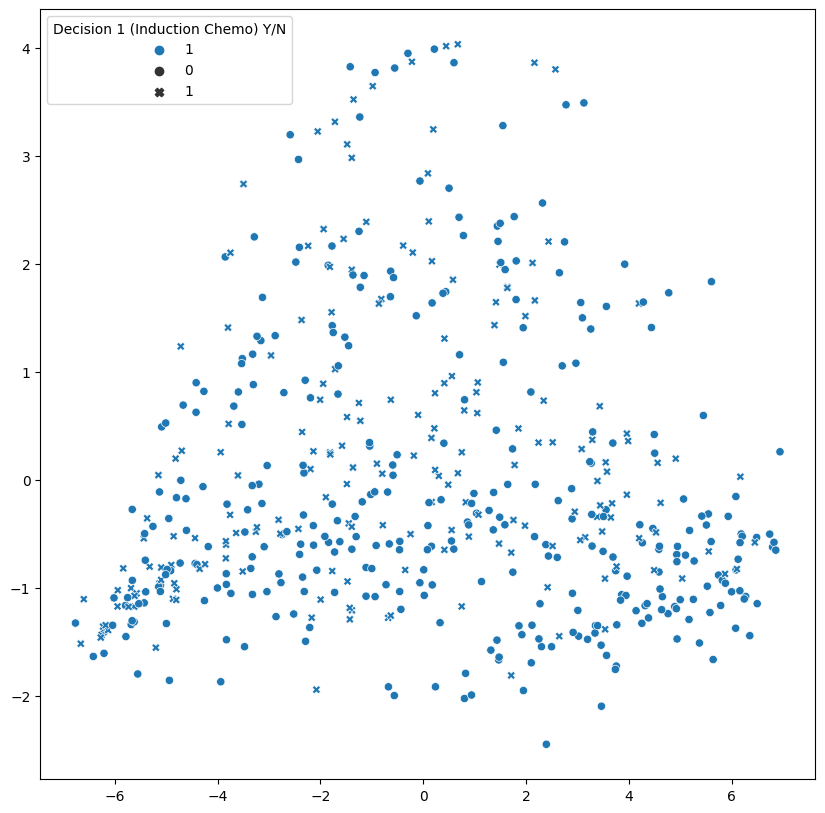

In [104]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embedding(dataset,dmodel,decision=0,ax=None,use_optimal=False):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    embeddings, decisions_optimal, decisions_imitation = get_embeddings(dataset,dmodel,states=[decision])
    pca = PCA(2)
    coords = pca.fit_transform(embeddings[0])
    marks = data.get_state('decision'+ str(decision+1))
    if use_optimal:
        predicted = (decisions_optimal > .5).ravel().astype(int)
    else:
        predicted = (decisions_imitation > .5).ravel().astype(int)
    sns.scatterplot(data=coords,
                    x=coords[:,0],
                    y=coords[:,1],
                    style=marks,
                    hue=predicted,
                    ax=ax,
                   )
plot_embedding(data,decision_model)

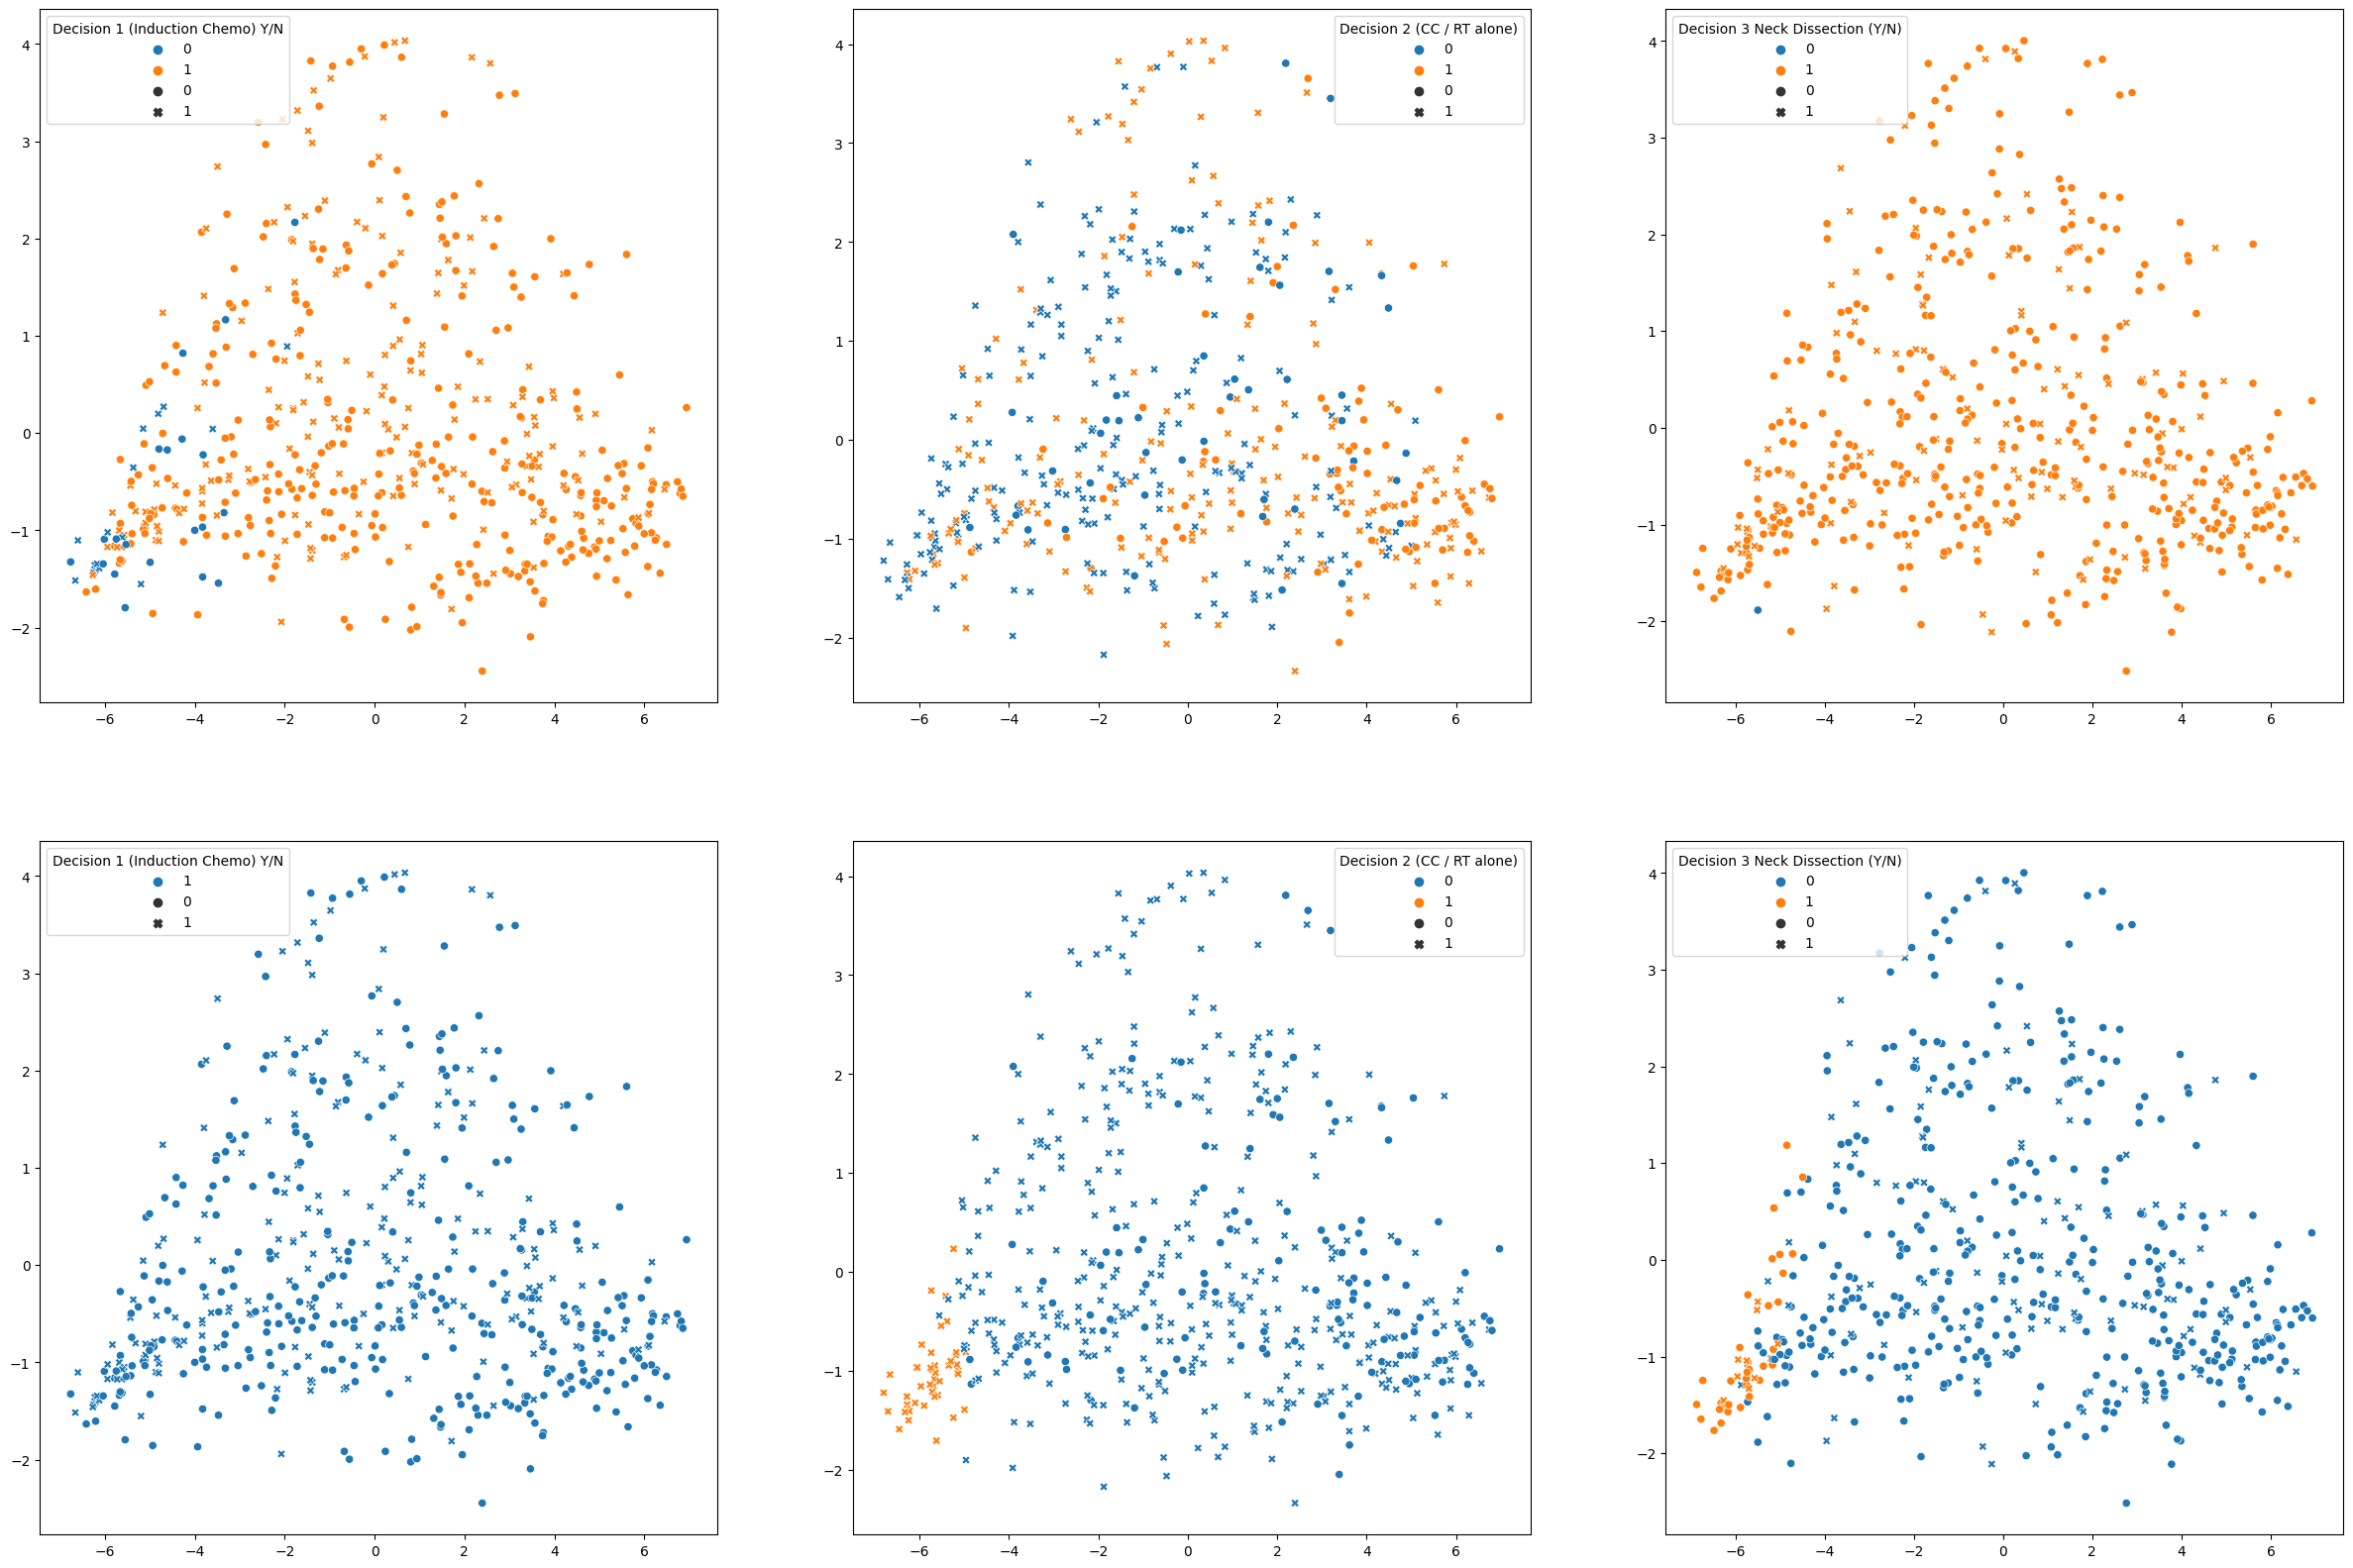

In [105]:
fig,axes = plt.subplots(2,3,figsize=(30,20))
for ii,opt in enumerate([True,False]):
    for i in range(3):
        plot_embedding(data,decision_model,use_optimal=opt,decision=i,ax=axes[ii,i])

In [13]:
def get_default_input(dataset,state=0,ids=None):
    output = get_decision_input(dataset,state=state,ids=ids)
    output = [o.median().to_dict() for o in output]
    return output

get_default_input(data)

[{'1A': 0.0,
  '1A1B': 0.0,
  '1A6': 0.0,
  '1B': 0.0,
  '1B2A': 0.0,
  '1B3': 0.0,
  '2A': 1.0,
  '2A2B': 1.0,
  '2A3': 0.0,
  '2B': 1.0,
  '2B5A': 0.0,
  '3': 0.0,
  '34': 0.0,
  '35A': 0.0,
  '36': 0.0,
  '4': 0.0,
  '45B': 0.0,
  '46': 0.0,
  '5A': 0.0,
  '5A5B': 0.0,
  '5B': 0.0,
  '6': 0.0,
  'AJCC_1': 0.0,
  'AJCC_2': 0.0,
  'AJCC_3': 0.0,
  'AJCC_4': 0.0,
  'Aspiration rate Pre-therapy': 0.0,
  'DLT (Y/N)': 0.0,
  'DLT_Grade': 0.0,
  'N-category_0': 0.0,
  'N-category_1': 0.0,
  'N-category_2': 0.0,
  'N-category_3': 0.0,
  'Pathological Grade_0': 0.0,
  'Pathological Grade_1': 0.0,
  'Pathological Grade_2': 0.0,
  'Pathological Grade_3': 1.0,
  'Pathological Grade_4': 0.0,
  'RPLN': 0.0,
  'T-category_1': 0.0,
  'T-category_2': 0.0,
  'T-category_3': 0.0,
  'T-category_4': 0.0,
  'age': 58.15555555555555,
  'bilateral': 0.0,
  'contra_spread': 0.0,
  'dose_fraction': 2.12121212121212,
  'gender': 1.0,
  'hpv': 1.0,
  'ips_spread': 0.4,
  'ln_cluster_1': 1.0,
  'ln_cluster_2': 

In [61]:
data.processed_df

,hpv,age,packs_per_year,smoking_status,gender,Aspiration rate Pre-therapy,total_dose,dose_fraction,1A1B,1A6,...,SD Primary 2,CR Nodal 2,PR Nodal 2,SD Nodal 2,Decision 1 (Induction Chemo) Y/N,Decision 2 (CC / RT alone),Decision 3 Neck Dissection (Y/N),Overall Survival (4 Years),FT,Aspiration rate Post-therapy
id,,,,,,,,,,,,,,,,,,,,,
3,1,55.969444,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,0,0,0
5,0,20.950000,38.0,1.0,1,0,72.00,1.800000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,0
6,1,69.930556,35.0,1.0,0,1,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,1
7,1,72.319444,0.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,1,0
8,1,59.730556,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,1,49.566667,30.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,1,0,0
10202,0,48.705556,30.0,1.0,1,0,72.00,1.714286,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,1,1,1,0
10203,1,77.116667,0.0,0.0,1,0,70.00,2.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,1,0,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_grid(df,columns):
    pass
plot_grid(data,['age','smoking_status','Decision 1 (Induction Chemo) Y/N','Decision 3 Neck Dissection (Y/N)',])

In [14]:
def format_patient(dataset,input_dict):
    #converts patient input features into data input type
    baselines = dataset.processed_df.median().to_dict()
    for k,v in input_dict.items():
        baselines[k] = v
    return baselines

format_patient(data,{'ln_cluster_3': 1,'DLT_Neurological': 1})

/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()


{'hpv': 1.0,
 'age': 58.15555555555555,
 'packs_per_year': 3.0,
 'smoking_status': 0.5,
 'gender': 1.0,
 'Aspiration rate Pre-therapy': 0.0,
 'total_dose': 70.0,
 'dose_fraction': 2.12121212121212,
 '1A1B': 0.0,
 '1A6': 0.0,
 '1B2A': 0.0,
 '1B3': 0.0,
 '2A2B': 1.0,
 '2A3': 0.0,
 '2B5A': 0.0,
 '34': 0.0,
 '35A': 0.0,
 '36': 0.0,
 '45B': 0.0,
 '46': 0.0,
 '5A5B': 0.0,
 'ips_spread': 0.4,
 'contra_spread': 0.0,
 '1A': 0.0,
 '1B': 0.0,
 '2A': 1.0,
 '2B': 1.0,
 '3': 0.0,
 '4': 0.0,
 '5A': 0.0,
 '5B': 0.0,
 '6': 0.0,
 'RPLN': 0.0,
 'bilateral': 0.0,
 'cc_none': 0.0,
 'cc_platinum': 0.0,
 'cc_cetuximab': 0.0,
 'cc_others': 0.0,
 'no_dose_adjustment': 1.0,
 'dose_modified': 0.0,
 'dose_delayed': 0.0,
 'dose_cancelled': 0.0,
 'dose_delayed_&_modified': 0.0,
 'regiment_modification': 0.0,
 'unknown': 0.0,
 'T-category_1': 0.0,
 'T-category_2': 0.0,
 'T-category_3': 0.0,
 'T-category_4': 0.0,
 'N-category_0': 0.0,
 'N-category_1': 0.0,
 'N-category_2': 0.0,
 'N-category_3': 0.0,
 'AJCC_1': 0.0,
 

In [29]:
def dict_to_model_input(dataset,fdict,state=0):
    fdict = format_patient(dataset,fdict)
    order = get_inputkey_order(dataset,state=state)
    inputs = [torch.tensor([fdict[k] for k in ordersubset]).type(torch.FloatTensor).view(1,-1) for ordersubset in order]
    #this is assuming the order is baseline, dlt1, dlt2, primary progression, nodal progression, cc type, dose modification
    def zeroinput(position):
        return torch.zeros(inputs[position].shape).type(torch.FloatTensor)
    if state == 0 or state == 1:
        inputs[2] = zeroinput(2)
        inputs[5] = zeroinput(5)
    if state < 1:
        inputs[1] = zeroinput(1)
        inputs[3] = zeroinput(3)
        inputs[4] = zeroinput(4)
        inputs[6] =zeroinput(6)
    #currently at this line its baseline, dlt1, dlt2, pd, nd, cc, modifications
    return inputs
# decision_model(*dict_to_model_input(data,data.processed_df.iloc[7].to_dict(),state=0),position=0)
dict_to_model_input(data,data.processed_df.iloc[7].to_dict(),state=0)

/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()


[tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
           0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000, 57.8583,  0.0000,  0.0000,  2.1212,  1.0000,
           1.0000,  0.4000,  1.0000,  0.0000,  0.0000,  0.0000, 44.0000,  1.0000,
           0.0000,  0.0000,  1.0000,  0.0000,  0.0000, 70.0000]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0.]]),
 tensor([[0., 0., 0.]]),
 tensor([[0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0.]])]

In [ ]:
transition_model1()

In [99]:
def dictify(keys,values):
    return {k:v for k,v in zip(keys,values)}

def get_stuff_for_patient(patient_dict,data,tmodel1,tmodel2,outcomemodel,decisionmodel):
    #this takes a patient dict and returns the results for a full treatment simulation
    #currently this is only the baseline and I need to think more about what to do with fixed values?
    pdata = format_patient(data,patient_dict)
    baseline_inputs = dict_to_model_input(data,pdata,state=0) 
    #inputs are order baseline, dlt1, dlt2, pd, nd, cc type, dose modifications
    #model output is nx6 -> optimal 1 , 2, 3, imitation 1, 2, 3
    cat = lambda x: torch.cat(x,axis=1)
    o1 = decisionmodel(cat(baseline_inputs),position=0)
    
    #do a loop for imitation and a loop for optimal decision making, mod = 3 is imitation
    format_transition = lambda x: torch.exp(x.view(1,-1))
    tmodel1.eval()
    tmodel2.eval()
    outcomemodel.eval()
    decisionmodel.eval()
    results = {}
    
    size_dict = decision_model.input_sizes
    
    #baseline, dlt1, dlt2, pd, nd, cc, mod
    input_keys = get_inputkey_order(data)
    def get_attention(xx, position, offset):
        attention = decision_model.get_attributions(cat(xx),target=position+offset, position=1)[0].detach().numpy()
        attention_dict = {
            'step': position,
            'model': 'optimal' if offset == 0 else 'imitation',
            'range': [float(attention.min()),float(attention.max())],
            'baseline': dictify(input_keys[0],attention[0:size_dict['baseline']]),
        }
        pos = size_dict['baseline']
        attention_dict['dlt1'] = dictify(input_keys[1],attention[pos:pos+size_dict['dlt']])
        pos += size_dict['dlt']
        attention_dict['dlt2'] = dictify(input_keys[2], attention[pos:pos+size_dict['dlt']])
        pos += size_dict['dlt']
        attention_dict['pd'] = dictify(input_keys[3], attention[pos:pos+size_dict['pd']])
        pos += size_dict['pd']
        attention_dict['nd'] = dictify(input_keys[4], attention[pos:pos+size_dict['nd']])
        pos += size_dict['nd']
        attention_dict['cc'] = dictify(input_keys[5], attention[pos:pos+size_dict['cc']])
        pos += size_dict['cc']
        attention_dict['modifications'] = dictify(input_keys[6], attention[pos:])
        return attention_dict
        
    thresh = lambda x: torch.gt(x,.5).type(torch.FloatTensor)
    def run_simulation(modifier,decision1=None,decision2=None,decision3=None):
        #transition 1 model uses usebaline + decision
        if decision1 is not None:
            d1 = torch.tensor([[decision1]]).type(torch.FloatTensor)
            d1_attention=0
        else:
            d1 = o1[:,0+modifier].view(1,-1)
            d1_attention = get_attention(baseline_inputs,0,modifier)
        tinput1 = torch.cat([baseline_inputs[0],thresh(d1)],axis=1)
        [ypd1,ynd1,ymod,ydlt1] = tmodel1(tinput1)
        [ypd1, ynd1, ymod] = [format_transition(i) for i in [ypd1,ynd1,ymod]]
        
        oinput2 = dict_to_model_input(data,pdata,state=1)
        oinput2[1] = ydlt1.view(1,-1)
        oinput2[3] = ypd1
        oinput2[4] = ynd1
        oinput2[6] = ymod
        
        if decision2 is not None:
            d2 = torch.tensor([[decision2]]).type(torch.FloatTensor)
            d2_attention=0
        else:
            d2 = decision_model(cat(oinput2),position=1)[:,1+modifier].view(1,-1)
            d2_attention = get_attention(oinput2,1,modifier)
        
        #transition 2 modle uses baseline + pd1 + nd1 + modification + dlt1 + decision 1 + deicsion 2
        tinput2 = [baseline_inputs[0], ypd1, ynd1, ymod,ydlt1, thresh(d1),thresh(d2)]

        tinput2 = torch.cat(tinput2,axis=1)
        [ypd2, ynd2, ycc, ydlt2] = tmodel2(tinput2)
        [ypd2, ynd2, ycc] = [format_transition(i) for i in [ypd2,ynd2,ycc]]
        
        oinput3 = oinput2[:]
        oinput3[2] = ydlt2.view(1,-1)
        oinput3[3] = ypd2
        oinput3[4] = ynd2
        oinput3[5] = ycc
        
        if decision3 is not None:
            d3 = torch.tensor([[decision3]]).type(torch.FloatTensor)
            d3_attention=0
        else:
            d3 = decision_model(cat(oinput3),position = 2)[:,2+modifier].view(1,-1)
            d3_attention = get_attention(oinput3,2,modifier)
        
        #outcomes uses baseline + pd2 + nd2 + cc type + dlt2 + decision 1,2,3
        tinput3 = [baseline_inputs[0], ypd2, ynd2, ycc, ydlt2, thresh(d1), thresh(d2), thresh(d3)]
        tinput3 = torch.cat(tinput3,axis=1)
        outcomes = outcomemodel(tinput3)
        
        entry = {
            'outcomes': outcomes.detach().numpy()[0],
            'pd1': ypd1.detach().numpy()[0],
            'nd1': ynd1.detach().numpy()[0],
            'pd2': ypd2.detach().numpy()[0],
            'nd2': ynd2.detach().numpy()[0],
            'modifications': ymod.detach().numpy()[0],
            'cc_type': ycc.detach().numpy()[0],
            'dlt1': ydlt1.detach().numpy()[0],
            'dlt2': ydlt2.detach().numpy()[0],
            'decision1': d1.detach().numpy()[0][0],
            'decision2': d2.detach().numpy()[0][0],
            'decision3': d3.detach().numpy()[0][0],
            'decision1_attention': d1_attention,
            'decision2_attention': d2_attention,
            'decision3_attention': d3_attention,
        }
        key = 'optimal' if modifier < 1 else 'imitation'
        if decision1 is not None:
            key += '_decision1-'+str(decision1)
        if decision2 is not None:
            key += '_decision2-'+str(decision2)
        if decision3 is not None:
            key += '_decision3-'+str(decision3)
        results[key] = entry
        
    for modifier in [0,3]:
        for d1_fixed in [None,0,1]:
            for d2_fixed in [None,0,1]:
                for d3_fixed in [None,0,1]:
                    run_simulation(modifier,d1_fixed,d2_fixed,d3_fixed)
    return results
test_patient = data.processed_df.iloc[7].to_dict()
test_results = get_stuff_for_patient(test_patient,data,transition_model1,transition_model2,outcome_model,decision_model)
test_results

/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or spe

/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or spe

/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baselines = dataset.processed_df.median().to_dict()
/tmp/ipykernel_45431/1768216535.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or spe

{'optimal': {'outcomes': array([0.81538117, 0.17691065, 0.18448818], dtype=float32),
  'pd1': array([0.6805301 , 0.28770474, 0.03176522], dtype=float32),
  'nd1': array([0.40129113, 0.5649965 , 0.03371237], dtype=float32),
  'pd2': array([0.8757491 , 0.1195945 , 0.00465629], dtype=float32),
  'nd2': array([0.53665423, 0.45420694, 0.00913887], dtype=float32),
  'modifications': array([0.69412005, 0.06050433, 0.02820722, 0.0858796 , 0.01671807,
         0.10900419, 0.00556653], dtype=float32),
  'cc_type': array([0.38405943, 0.24798787, 0.32969376, 0.03825896], dtype=float32),
  'dlt1': array([0.06195168, 0.02564614, 0.02834067, 0.08287958, 0.09357791,
         0.01916381, 0.06879617, 0.03184534], dtype=float32),
  'dlt2': array([0.02841459, 0.01762782, 0.00806038, 0.0335149 , 0.02173762,
         0.00829141, 0.04506678, 0.02270377], dtype=float32),
  'decision1': 0.4661419,
  'decision2': 0.50229144,
  'decision3': 0.57485014,
  'decision1_attention': {'step': 0,
   'model': 'optimal',


In [100]:
for k,v in test_results.items():
    print(k,v['outcomes'])

optimal [0.81538117 0.17691065 0.18448818]
optimal_decision3-0 [0.8355625  0.15250228 0.15493275]
optimal_decision3-1 [0.81538117 0.17691065 0.18448818]
optimal_decision2-0 [0.8228768  0.14692149 0.16236758]
optimal_decision2-0_decision3-0 [0.84505624 0.12535523 0.13736233]
optimal_decision2-0_decision3-1 [0.8228768  0.14692149 0.16236758]
optimal_decision2-1 [0.81538117 0.17691065 0.18448818]
optimal_decision2-1_decision3-0 [0.8355625  0.15250228 0.15493275]
optimal_decision2-1_decision3-1 [0.81538117 0.17691065 0.18448818]
optimal_decision1-0 [0.81538117 0.17691065 0.18448818]
optimal_decision1-0_decision3-0 [0.8355625  0.15250228 0.15493275]
optimal_decision1-0_decision3-1 [0.81538117 0.17691065 0.18448818]
optimal_decision1-0_decision2-0 [0.8228768  0.14692149 0.16236758]
optimal_decision1-0_decision2-0_decision3-0 [0.84505624 0.12535523 0.13736233]
optimal_decision1-0_decision2-0_decision3-1 [0.8228768  0.14692149 0.16236758]
optimal_decision1-0_decision2-1 [0.81538117 0.17691065 